<a href="https://colab.research.google.com/github/MichaelYeung2004/pytorch_tytorials/blob/main/2_autograd_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#torch.autograd 入门教程

`torch.autograd` 是 PyTorch 的自动微分引擎，为神经网络训练提供动力。在本节中，你将从概念上理解 autograd 是如何帮助神经网络进行训练的。

##背景
神经网络 (NNs) 是作用于某些输入数据上的一系列嵌套函数。这些函数由参数（包括权重和偏置）定义，在 PyTorch 中，这些参数存储在张量（tensor）中。

训练一个神经网络分为两个步骤：

**前向传播 (Forward Propagation):** 在前向传播中，神经网络对其认为正确的输出做出最佳猜测。它让输入数据流经每一个函数来做出这个猜测。

**反向传播 (Backward Propagation):** 在反向传播中，神经网络根据其猜测的误差成比例地调整其参数。它通过从输出开始反向遍历，收集误差相对于函数参数的导数（即**梯度**），并使用梯度下降来优化参数。想更深入地了解反向传播，请观看 [3Blue1Brown](https://www.google.com/url?sa=E&q=https%3A%2F%2Fwww.youtube.com%2Fwatch%3Fv%3DIlg3gGewQ5U) 的这个视频。

##在 PyTorch 中的使用
我们来看一个单步训练的例子。在这个例子中，我们从 torchvision 加载一个预训练的 resnet18 模型。我们创建一个随机数据张量来表示一个具有 3 个通道、高和宽均为 64 的单张图片，以及其对应的标签（初始化为一些随机值）。在预训练模型中，标签的形状为 (1, 1000)。

>注意
本教程仅在 CPU 上运行，无法在 GPU 设备上工作（即使张量被移动到 CUDA）。

In [2]:
import torch # 导入torch库
from torchvision.models import resnet18, ResNet18_Weights # 导入resnet18模型
model = resnet18(weights=ResNet18_Weights.DEFAULT) # 加载resnet18模型
data = torch.rand(1, 3, 64, 64) # 创建一个1x3x64x64的张量
labels = torch.rand(1, 1000) # 创建一个1x1000的张量

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 84.9MB/s]


接下来，我们让输入数据通过模型的每一层，以进行预测。这就是**前向传播**。

In [3]:
prediction = model(data) # 前向传播
print(prediction) # 打印预测结果

tensor([[-4.9530e-01, -7.8792e-01, -6.1362e-01, -1.6742e+00, -7.5752e-01,
         -4.7912e-01, -8.4931e-01,  3.9081e-01,  2.3745e-01, -1.0047e+00,
         -9.2826e-01, -8.4946e-01, -2.2649e-02, -9.0601e-01, -1.1432e+00,
         -3.8299e-01, -7.3267e-01, -2.6334e-01, -4.3612e-01, -3.5710e-01,
         -1.5683e+00, -7.1546e-01, -1.7900e+00,  9.8207e-02, -8.8643e-01,
         -9.5062e-01, -6.9475e-01, -1.1729e+00, -7.0029e-01, -7.0490e-01,
         -6.1555e-01, -7.2706e-01, -2.1651e-01, -5.9308e-01, -4.5647e-01,
         -3.3289e-01,  6.0432e-01, -5.7369e-01, -3.2935e-01,  1.5166e-01,
         -6.8280e-01, -6.8452e-01, -9.5735e-01, -3.1721e-01, -6.1356e-01,
         -3.7029e-01, -7.4383e-01, -1.8931e-01, -1.1455e+00, -1.3509e+00,
         -4.6940e-01,  6.3680e-01, -9.0210e-02, -4.7894e-01, -1.8549e-01,
         -9.7505e-01, -1.3229e-01, -1.1156e+00, -2.3980e-01, -2.0381e-01,
          9.9811e-01,  1.1145e-01, -5.5093e-02,  3.8330e-01, -5.6889e-01,
         -9.1272e-02, -1.5755e-01, -2.

我们使用模型的预测值和相应的标签来计算误差（loss）。下一步是沿着网络反向传播这个误差。当我们对误差张量调用 `.backward()` 时，反向传播就开始了。Autograd 随后会计算每个模型参数的梯度，并将其存储在参数的 `.grad` 属性中。

In [4]:
loss = (prediction - labels).sum() # 计算损失
loss.backward() # 反向传播

接着，我们加载一个优化器，这里我们使用随机梯度下降（SGD），学习率为 0.01，动量为 0.9。我们将模型的所有参数注册到优化器中。

In [5]:
optim = torch.optim.SGD(model.parameters(), lr=1e-2, momentum=0.9) # 创建优化器

最后，我们调用 `.step()` 来启动梯度下降。优化器会根据存储在 `.grad` 中的梯度来调整每个参数。

In [6]:
optim.step() # 梯度下降

至此，你已经掌握了训练神经网络所需的一切。以下各节将详细介绍 autograd 的工作原理——如果你不感兴趣，可以跳过它们。

## Autograd 中的微分
我们来看看 autograd 是如何收集梯度的。我们创建两个张量 `a` 和 `b`，并设置 `requires_grad=True`。这会向 autograd 发出信号，表明对它们的所有操作都应被追踪。

In [7]:
import torch
a = torch.tensor([2., 3.], requires_grad=True)
b = torch.tensor([6., 4.], requires_grad=True)

我们用 `a` 和 `b` 创建另一个张量 `Q`。
$$
Q = 3a^3 - b^2
$$

In [8]:
Q = 3*a**3 - b**2

假设 `a` 和 `b` 是一个神经网络的参数，而 `Q` 是误差。在神经网络训练中，我们想要的是误差关于参数的梯度，即：
$$
\frac{\partial Q}{\partial a} = 9a^2
$$
$$
\frac{\partial Q}{\partial b} = -2b
$$
当我们对 `Q` 调用 `.backward()` 时，autograd 会计算这些梯度并将它们存储在对应张量的 `.grad` 属性中。

我们需要在 `Q.backward()` 中显式地传递一个 `gradient` 参数，因为 `Q` 是一个向量。`gradient` 是一个与 `Q` 形状相同的张量，它代表 `Q` 相对于其自身的梯度，即：
$$
\frac{dQ}{dQ} = 1
$$
等价地，我们也可以将 `Q` 聚合成一个标量并隐式地调用 backward，例如 `Q.sum().backward()`。

In [9]:
external_grad = torch.tensor([1., 1.])
Q.backward(gradient=external_grad) #计算梯度

现在梯度已经被存储在 `a.grad` 和 `b.grad` 中了。

In [10]:
# 检查收集的梯度是否正确
print(9*a**2 == a.grad)
print(-2*b == b.grad)

tensor([True, True])
tensor([True, True])


### 选读 - 使用 autograd 进行向量微积分
从数学上讲，如果你有一个向量值函数 $\vec{y} = f(\vec{x})$，那么 $\vec{y}$ 关于 $\vec{x}$ 的梯度是一个雅可比矩阵 $J$:
$$
J = \begin{pmatrix} \frac{\partial y}{\partial x_1} & ... & \frac{\partial y}{\partial x_n} \end{pmatrix} = \begin{pmatrix} \frac{\partial y_1}{\partial x_1} & \cdots & \frac{\partial y_1}{\partial x_n} \\ \vdots & \ddots & \vdots \\ \frac{\partial y_m}{\partial x_1} & \cdots & \frac{\partial y_m}{\partial x_n} \end{pmatrix}
$$
总的来说，`torch.autograd` 是一个用于计算**向量-雅可比积**的引擎。也就是说，给定任何向量 $\vec{v}$，计算乘积 $J^T \cdot \vec{v}$。

如果 $\vec{v}$ 恰好是一个标量函数 $l=g(\vec{y})$ 的梯度：
$$
\vec{v} = \begin{pmatrix} \frac{\partial l}{\partial y_1} & \cdots & \frac{\partial l}{\partial y_m} \end{pmatrix}^T
$$
那么根据链式法则，向量-雅可比积就是 $l$ 关于 $\vec{x}$ 的梯度：
$$
J^T \cdot \vec{v} = \begin{pmatrix} \frac{\partial y_1}{\partial x_1} & \cdots & \frac{\partial y_m}{\partial x_1} \\ \vdots & \ddots & \vdots \\ \frac{\partial y_1}{\partial x_n} & \cdots & \frac{\partial y_m}{\partial x_n} \end{pmatrix} \begin{pmatrix} \frac{\partial l}{\partial y_1} \\ \vdots \\ \frac{\partial l}{\partial y_m} \end{pmatrix} = \begin{pmatrix} \frac{\partial l}{\partial x_1} \\ \vdots \\ \frac{\partial l}{\partial x_n} \end{pmatrix}
$$
向量-雅可比积的这个特性正是我们在上一个例子中使用的；`external_grad` 就代表了向量 $\vec{v}$。

## 计算图 (Computational Graph)
从概念上讲，autograd 在一个由 `Function` 对象组成的**有向无环图 (DAG)** 中记录了数据（张量）和所有执行的操作（以及由此产生的新张量）。在这个 DAG 中，叶节点是输入张量，根节点是输出张量。通过从根到叶追溯这个图，你可以使用链式法则自动计算梯度。

在前向传播中，autograd 同时做两件事：
*   运行请求的操作以计算结果张量。
*   在 DAG 中维护该操作的梯度函数。

当在 DAG 的根节点上调用 `.backward()` 时，反向传播就开始了。`autograd` 接着会：
*   从每个 `.grad_fn` 计算梯度。
*   将它们累加到相应张量的 `.grad` 属性中。
*   使用链式法则，一直传播到叶节点张量。

下面是我们的例子中 DAG 的一个可视化表示。在图中，箭头指向前向传播的方向。节点代表前向传播中每个操作的反向函数。蓝色的叶节点代表我们的叶张量 `a` 和 `b`。

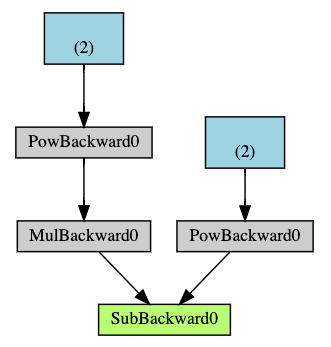
> **注意**
>
> **PyTorch 中的 DAG 是动态的**
> 一个重点是，图是从头开始重新创建的；在每次 `.backward()` 调用之后，autograd 都会开始构建一个新的图。这正是允许你在模型中使用控制流语句的原因；如果需要，你可以在每次迭代中改变形状、大小和操作。

### 从 DAG 中排除
`torch.autograd` 会追踪所有 `requires_grad` 标志为 `True` 的张量上的操作。对于不需要梯度的张量，将其 `requires_grad` 属性设置为 `False` 会将其从梯度计算的 DAG 中排除。

即使只有一个输入张量设置了 `requires_grad=True`，操作的输出张量也将需要梯度。

In [11]:
x = torch.rand(5, 5) # 创建一个5x5的张量
y = torch.rand(5, 5) # 创建一个5x5的张量
z = torch.rand((5, 5), requires_grad=True) # 创建一个5x5的张量，并设置requires_grad=True

a = x + y # 计算x和y的和
print(f"a 是否需要梯度?: {a.requires_grad}") # 打印a是否需要梯度
b = x + z # 计算x和z的和
print(f"b 是否需要梯度?: {b.requires_grad}") # 打印b是否需要梯度

a 是否需要梯度?: False
b 是否需要梯度?: True


在神经网络中，不计算梯度的参数通常被称为**冻结参数** (frozen parameters)。如果你预先知道你不需要某些参数的梯度，那么“冻结”模型的一部分会很有用（这通过减少 autograd 的计算来提供一些性能优势）。

在微调（finetuning）中，我们冻结模型的大部分，通常只修改分类器层来对新标签进行预测。让我们通过一个小例子来演示这一点。和之前一样，我们加载一个预训练的 resnet18 模型，并冻结所有参数。

In [12]:
from torch import nn, optim

model = resnet18(weights=ResNet18_Weights.DEFAULT)

# 冻结网络中的所有参数
for param in model.parameters():
    param.requires_grad = False

假设我们想在一个有 10 个标签的新数据集上微调模型。在 resnet 中，分类器是最后一个线性层 `model.fc`。我们可以简单地用一个新的线性层（默认情况下是未冻结的）替换它，作为我们的分类器。

In [13]:
model.fc = nn.Linear(512, 10)  # 将模型的最后一层替换为一个新的全连接层

现在，除了 `model.fc` 的参数外，模型中的所有参数都被冻结了。唯一计算梯度的参数是 `model.fc` 的权重和偏置。

In [14]:
# 只优化分类器
optimizer = optim.SGD(model.parameters(), lr=1e-2, momentum=0.9)

注意，尽管我们在优化器中注册了所有的参数，但唯一计算梯度（并因此在梯度下降中更新）的参数是分类器的权重和偏置。

同样，`torch.no_grad()` 上下文管理器也提供了这种排除计算的功能。